# Data Preparation for the Nord_H2ub Spine Model

This jupyter notebook contains all routines for the preparation of the input data sources into a input data file for the model in Spine. 

**Authors:** Johannes Giehl (jfg.eco@cbs.dk), Dana J. Hentschel (djh.eco@cbs.dk)

## General settings

### Packages:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

### Methods:

In [2]:
#load the functions and methods from the corresponding file
from nord_h2ub_data_preparation_functions import *

### Base parameters

In [3]:
#define year and create time stamp
year = 2019   #change to desired year
start_date = pd.Timestamp(str(year) + '-01-01 00:00:00')
end_date = pd.Timestamp(str(year) + '-12-31 23:00:00')
#set area
area = 'DK1'   #change to desired area
#set product
product = 'methanol'   #change to desired product
#scenario
scenario = 'Base'
#frequency model
frequency = '1h'
#model name
model_name = 'toy'
#temporal block
temporal_block = 'hourly'
#stochastics
stochastic_scenario = "realisation"
stochastic_structure = "deterministic"
#required reports
report_name = 'Report'
reports = ['unit_flow', 'connection_flow', 'node_state', 'total_costs', 'unit_flow_op', 'node_slack_neg', 'node_slack_pos']

#variable efficiency electrolyzer
electrolyzer_type = "Alkaline"   #change to desired type (PEM, Alkaline, SOEC)
des_segments_electrolyzer = 10  #operating points for piecewise linear function, set by user 

# Print warning message in red
print("\033[91mWARNING:\033[0m Please control if all the parameters are set correctly")

In [4]:
#financial parameters for the calculations
#when using the district heating as a revenue stream, the price cap is the upper limit in Denmark
#by using this parameter this can be adjusted to start with other than the max value
share_of_dh_price_cap = 0.5

In [5]:
#define parameters for the use of the roll forward (rolling horizon) approach

#set the number of slices within the modelling horizon
roll_forward_use = True
num_slices = 12

# Create DatetimeIndex for the range of dates
datetime_index = pd.date_range(start=start_date, end=end_date, freq=frequency)

# Calculate the number of steps within the horizon
num_steps = len(datetime_index)

# Check if the number of slices can be used
# Find the largest integer divisor that fulfils the condition
for i in range(num_slices, 0, -1):
    if num_steps % i == 0:
        roll_forward_size = num_steps // i
        used_slices = i
        break
else:
    print("Cannot divide the number of steps into any integer slices. Please choose a different number of slices.")
    exit()

# Check if num_slices matches the used_slices
if num_slices != used_slices:
    print("\033[91mWARNING:\033[0m The specified number of slices (", num_slices, ")",
          "does not match the final division factor (", used_slices, ").",
         "\n The calculation uses the factor: ",used_slices, ".")

### File paths

In [6]:
#set path to correct folders

#input data
excel_file_path = '../01_input_data/01_input_raw/'
#prepared input data
output_file_path = '../01_input_data/02_input_prepared/'

In [7]:
#set name of the relevant files

Model_structure_file = '/Model_Data_Base.xlsx'
variable_efficiency_file = '/variable_efficiency.xlsx'
efficiency_electrolyzer_file = '/Efficiency_Electrolyzers.xlsx'
distric_heating_price_file = 'energy_prices/district_heating_price_cap.xlsx'

PV_data_availabilityfactors = 'PV_availability_factors_Kasso_' + str(year) + '.xlsx'
data_powerprices = 'Day_ahead_prices_' + str(year) + '.xlsx'

#output file
output_file_name = product+'_Input_prepared.xlsx'


## Workflow of the data preparation

### General parameters

In [8]:
#date index
date_index = pd.date_range(start=start_date, end=end_date, freq='H')
formatted_dates = date_index.strftime('%Y-%m-%dT%H:%M:%S')
df_formatted_dates = pd.DataFrame(formatted_dates, columns=['DateTime'])

df_time = pd.DataFrame(df_formatted_dates)

### Data import

In [9]:
#read in the model structure from a new excel
df_model_units = pd.read_excel(excel_file_path + product + Model_structure_file, sheet_name='Units', index_col=None)
df_model_connections = pd.read_excel(excel_file_path + product + Model_structure_file, sheet_name='Connections', index_col=None)
df_model_storages = pd.read_excel(excel_file_path + product + Model_structure_file, sheet_name='Storages', index_col=None)
#Variable efficiency
df_efficiency_electrolyzer = pd.read_excel(excel_file_path + product + efficiency_electrolyzer_file, sheet_name='Efficiency_'+electrolyzer_type)
#Availability factor
df_PV_availabilityfactors_values = pd.read_excel(excel_file_path+PV_data_availabilityfactors, skiprows=2, usecols=[0,1,2,3,4,5])
#Power prices
df_powerprices_total_values = pd.read_excel(excel_file_path+data_powerprices)
#only extracting the prices from our earlier defined area
df_powerprices_values = df_powerprices_total_values[df_powerprices_total_values['PriceArea'] == area]
df_powerprices_values = df_powerprices_values.reset_index(drop=True)
#district heating prices
df_district_heating_price = pd.read_excel(excel_file_path + distric_heating_price_file, sheet_name='Price_Cap_Calculation', index_col=None)

### Adjustments

#### Adjust base elements:

In [10]:
#Create a dataframe for units
df_units = df_model_units[['Unit']].copy()
df_units['Category'] = 'unit'
#df_units['fom_cost'] = df_model_units[['fom_cost']]
df_units = df_units.rename(columns={'Unit': 'Object_Name'})

#Create a dataframe for connections
df_connections = df_model_connections[['Connection']].copy()
df_connections['Category'] = 'connection'
df_connections = df_connections.rename(columns={'Connection': 'Object_Name'})
#df_connections['fom_cost'] = df_model_connections[['fom_cost']]

#create a list of nodes of the model
U_input1_nodes = df_model_units['Input1'].tolist()
U_input2_nodes = df_model_units['Input2'].tolist()
U_output1_nodes = df_model_units['Output1'].tolist()
U_output2_nodes = df_model_units['Output2'].tolist()
C_input1_nodes = df_model_connections['Input1'].tolist()
C_input2_nodes = df_model_connections['Input2'].tolist()
C_output1_nodes = df_model_connections['Output1'].tolist()
C_output2_nodes = df_model_connections['Output2'].tolist()

# Combine values from both columns into a single list
All_nodes_list = U_input1_nodes+U_input2_nodes+U_output1_nodes+U_output2_nodes+C_input1_nodes+C_input2_nodes+C_output1_nodes+C_output2_nodes

# Create a list with unique entries
unique_nodes_list = list(set(All_nodes_list))

#Create a dataframe for nodes
df_nodes = pd.DataFrame(unique_nodes_list, columns=['Object_Name'])
df_nodes['Category'] = 'node'
df_nodes = df_nodes.dropna()

#Combined dataframe
df_definition = pd.concat([df_units, df_nodes, df_connections], ignore_index=True)

df_definition.head()

,Object_Name,Category
0,Solar_Plant_Kasso,unit
1,Electrolyzer,unit
2,CO2_Vaporizer,unit
3,Destilation_Tower,unit
4,Methanol_Reactor,unit


In [11]:
#create a data frame for all parameters of units

#add fixed operation and maintenance cost
unit_fom_cost_df = create_unit_parameters(df_model_units, 'Unit', 'fom_cost')
#add unit minimal downtime
unit_min_down_time_df = create_unit_parameters(df_model_units, 'Unit', 'min_down_time')
#add unit on cost
unit_on_cost_df = create_unit_parameters(df_model_units, 'Unit', 'unit_on_cost')

connection_fom_cost_df = create_unit_parameters(df_model_connections, 'Connection', 'fom_cost')

#create a complete data frame with all parameters
unit_parameters_df = pd.concat([unit_fom_cost_df, unit_on_cost_df, unit_min_down_time_df, connection_fom_cost_df], ignore_index=True)
unit_parameters_df

C:\Users\jfg.eco\Documents\GitHub\Nord_H2ub\spine_projects\01_input_data\nord_h2ub_data_preparation_functions.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  unit_parameter_df = pd.concat([unit_parameter_df, pd.DataFrame([new_row])], ignore_index=True)
C:\Users\jfg.eco\Documents\GitHub\Nord_H2ub\spine_projects\01_input_data\nord_h2ub_data_preparation_functions.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  unit_parameter_df = pd.concat([unit_parameter_df, pd.DataFrame([new_row])], ign

,Object_Name,Category,parameter,value
0,Solar_Plant_Kasso,unit,fom_cost,1.29
1,Electrolyzer,unit,fom_cost,4.34
2,Methanol_Reactor,unit,fom_cost,4.45
3,Steam_Plant,unit,fom_cost,0.119292
4,Methanol_Reactor,unit,min_down_time,48h
5,Methanol_Reactor,unit,online_variable_type,unit_online_variable_type_integer
6,pipeline_storage_hydrogen,connection,fom_cost,0.072836
7,pipeline_storage_e-methanol,connection,fom_cost,0.010959


In [12]:
#create a new data frame for parameters that are given as durations
#necessary as SpineToolbox needs a separate input to map the parameter correctly

duration_parameter = 'min_down_time'
unit_parameters_duration_df = unit_parameters_df[unit_parameters_df['parameter'] == duration_parameter]
# Resetting the index
unit_parameters_duration_df = unit_parameters_duration_df.reset_index(drop=True)

# Creating another DataFrame with rows that do not meet the condition
unit_parameters_rest_df = unit_parameters_df[unit_parameters_df['parameter'] != duration_parameter]
unit_parameters_rest_df

,Object_Name,Category,parameter,value
0,Solar_Plant_Kasso,unit,fom_cost,1.29
1,Electrolyzer,unit,fom_cost,4.34
2,Methanol_Reactor,unit,fom_cost,4.45
3,Steam_Plant,unit,fom_cost,0.119292
5,Methanol_Reactor,unit,online_variable_type,unit_online_variable_type_integer
6,pipeline_storage_hydrogen,connection,fom_cost,0.072836
7,pipeline_storage_e-methanol,connection,fom_cost,0.010959


In [13]:
#create the balance type of the nodes
columns_to_select = ['Input1', 'Input2', 'Output1', 'Output2']
df_combined = pd.concat([df_model_units, df_model_connections])
df_combined = df_combined.reset_index(drop=True)

df_nodes_network = create_connection_dataframe(df_combined, columns_to_select)

# Get unique values from the 'in' column
unique_in_values = df_nodes_network['in'].dropna().unique()

# Identify values in 'in' column not present in 'out' column
values_not_in_out = unique_in_values[~pd.Series(unique_in_values).isin(df_nodes_network['out'].dropna().unique())]

# Get unique values from the 'in' column
unique_out_values = df_nodes_network['out'].dropna().unique()

# Identify values in 'in' column not present in 'out' column
values_not_in_in = unique_out_values[~pd.Series(unique_out_values).isin(df_nodes_network['in'].dropna().unique())]

#create list of unique nodes that are either start or end nodes
unique_nodes = values_not_in_out.tolist() + values_not_in_in.tolist()
unique_nodes

df_nodes_network.replace(np.nan, None, inplace=True)

#check for combinations that are mirrored
mirrored_combinations = find_mirror_combinations(df_nodes_network)

#get information of connections for each node
partners_dict1 = find_partners(df_nodes_network)
partners_dict2 = find_partners(mirrored_combinations)

#check both lists if there are identical entries and list nodes that only have a connection to the same node
#storages are removed as they must be balanced
nodes_identical = find_identical_entries(partners_dict1, partners_dict2)

#combined list of start and end nodes that should be unbalanced
unbalanced_nodes = nodes_identical + unique_nodes

df_nodes['balance_type'] = 'balance_type_node'
df_nodes.loc[df_nodes['Object_Name'].isin(unbalanced_nodes), 'balance_type'] = 'balance_type_none'

In [14]:
#add has_state_node_state_cap and frac_state_loss
df_storages_short = df_model_storages.loc[:, ['Storage', 'has_state', 'node_state_cap', 'frac_state_loss']].rename(columns={'Storage': 'Object_Name'})
df_storages_short['has_state'] = df_storages_short['has_state'].astype(str).str.lower().replace('true', 'true')

df_nodes = pd.merge(df_nodes, df_storages_short, on='Object_Name', how='left')
df_nodes.head()

,Object_Name,Category,balance_type,has_state,node_state_cap,frac_state_loss
0,Power_Kasso,node,balance_type_node,NaN,NaN,NaN
1,Power_Wholesale,node,balance_type_none,NaN,NaN,NaN
2,Raw_Methanol,node,balance_type_node,NaN,NaN,NaN
3,Carbon_Dioxide,node,balance_type_none,NaN,NaN,NaN
4,Water,node,balance_type_none,NaN,NaN,NaN


In [15]:
#create a dataframe with all nodes that should have a slack based on the unit input and outputs
nodes_for_slack_df = check_entries_exist(df_model_units, 'node')
#merge the information into the prepared data frame
merged_df = pd.merge(df_nodes, nodes_for_slack_df, left_on='Object_Name', right_on='node', how='left')
merged_df = merged_df.drop(columns=['node'])
merged_df['node_slack_penalty'] = merged_df['node_slack_penalty'].replace({True: 100000, False: ''})
#create a dataframe with all nodes that should have a slack based on the connection input and outputs
nodes_for_slack_df2 = check_entries_exist(df_model_connections, 'connection')
#merge the information into the prepared data frame
merged_df2 = pd.merge(df_nodes, nodes_for_slack_df2, left_on='Object_Name', right_on='connection', how='left')
merged_df2 = merged_df2.drop(columns=['connection'])
merged_df2['node_slack_penalty'] = merged_df2['node_slack_penalty'].replace({True: 100000, False: ''})
#link the information about the slack of both data frames
merged_df2['node_slack_penalty'] = merged_df['node_slack_penalty'].combine_first(merged_df2['node_slack_penalty'])
#clean the information that only nodes with 'balance_type_node' have a penalty
merged_df2.loc[merged_df2['balance_type'] == 'balance_type_none', 'node_slack_penalty'] = ''
#add the information into the df_nodes
df_nodes['node_slack_penalty'] = merged_df2['node_slack_penalty']

#show table head for control
df_nodes.head()

,Object_Name,Category,balance_type,has_state,node_state_cap,frac_state_loss,node_slack_penalty
0,Power_Kasso,node,balance_type_node,NaN,NaN,NaN,100000
1,Power_Wholesale,node,balance_type_none,NaN,NaN,NaN,
2,Raw_Methanol,node,balance_type_node,NaN,NaN,NaN,100000
3,Carbon_Dioxide,node,balance_type_none,NaN,NaN,NaN,
4,Water,node,balance_type_none,NaN,NaN,NaN,


In [16]:
#Add parameters for connections
df_connections = df_model_connections.loc[:, ['Connection', 'Connection_type']]
insert_index=1
parameter_name = ['connection_type']*len(df_connections)
df_connections.insert(insert_index, 'Parameter_name', parameter_name)
#show table for control
df_connections.head()

,Connection,Parameter_name,Connection_type
0,power_line_Wholesale_Kasso,connection_type,connection_type_lossless_bidirectional
1,pipeline_storage_hydrogen,connection_type,connection_type_lossless_bidirectional
2,pipeline_storage_e-methanol,connection_type,connection_type_lossless_bidirectional
3,pipeline_District_Heating,connection_type,connection_type_normal


#### Times series:

In [17]:
#adjust PV columns names
df_PV_availabilityfactors_values.rename(columns={'time': 'time [UTC]', 
                                                 'local_time': 'time [' + area + ']',
                                                 'electricity': 'unit_availability_factor'}, inplace=True)
df_powerprices_values.rename(columns={'HourUTC': 'time [UTC]', 
                                         'HourDK': 'time [' + area + ']'}, inplace=True)

### Fitting data into format

#### Relationships:

Object__from/to_node:

In [18]:
### UNITS ###
# Initialize an empty list to store the transformed data
unit_relation_parameter_data = []

# Iterate over each row in the DataFrame
for index, row in df_model_units.iterrows():
    unit = row['Unit']

    # Iterate over Input and Output columns
    for i in range(1, 3):
        input_col = f'Input{i}'
        output_col = f'Output{i}'
        cap_input_col = f'Cap_{input_col}_existing'
        cap_output_col = f'Cap_{output_col}_existing'
        vom_cost_input_col = f'vom_cost_{input_col}'
        vom_cost_output_col = f'vom_cost_{output_col}'
        ramp_up_output_col = f'ramp_up_{output_col}'
        ramp_down_output_col = f'ramp_down_{output_col}'
        start_up_output_col = f'start_up_{output_col}'
        shut_down_output_col = f'shut_down_{output_col}'
        minimum_operating_point = f'minimum_op_point'

        # Check for Input columns
        input_value = row[input_col]
        input_capacity = row[cap_input_col]
        vom_cost_input = row[vom_cost_input_col]
        minimum_op = row[minimum_operating_point]

        if pd.notna(input_value):
            unit_relation_parameter_data.append({
                'Relationship_class_name': 'unit__from_node',
                'Object_class': 'unit',
                'Object_name': unit,
                'Node': input_value,
                'Parameter': 'unit_capacity' if pd.notna(input_capacity) else '',
                'Value': input_capacity if pd.notna(input_capacity) else ''
            })
        
            if pd.notna(input_value) and pd.notna(vom_cost_input):
                unit_relation_parameter_data.append({
                    'Relationship_class_name': 'unit__from_node',
                    'Object_class': 'unit',
                    'Object_name': unit,
                    'Node': input_value,
                    'Parameter': 'vom_cost',
                    'Value': vom_cost_input
                })
            
            if pd.notna(input_value) and pd.notna(input_capacity) and pd.notna(minimum_op):
                unit_relation_parameter_data.append({
                    'Relationship_class_name': 'unit__from_node',
                    'Object_class': 'unit',
                    'Object_name': unit,
                    'Node': input_value,
                    'Parameter': 'minimum_operating_point',
                    'Value': minimum_op
                })


        # Check for Output columns
        output_value = row[output_col]
        output_capacity = row[cap_output_col]
        vom_cost_output = row[vom_cost_output_col]
        ramp_up_output = row[ramp_up_output_col]
        ramp_down_output = row[ramp_down_output_col]
        start_up_output = row[start_up_output_col]
        shut_down_output = row[shut_down_output_col]

        if pd.notna(output_value):
            unit_relation_parameter_data.append({
                'Relationship_class_name': 'unit__to_node',
                'Object_class': 'unit',
                'Object_name': unit,
                'Node': output_value,
                'Parameter': 'unit_capacity' if pd.notna(output_capacity) else '',
                'Value': output_capacity if pd.notna(output_capacity) else ''
            })
        
            if pd.notna(output_value) and pd.notna(vom_cost_output):
                unit_relation_parameter_data.append({
                    'Relationship_class_name': 'unit__to_node',
                    'Object_class': 'unit',
                    'Object_name': unit,
                    'Node': output_value,
                    'Parameter': 'vom_cost',
                    'Value': vom_cost_output
                })

            if pd.notna(output_value) and pd.notna(ramp_up_output):
                unit_relation_parameter_data.append({
                    'Relationship_class_name': 'unit__to_node',
                    'Object_class': 'unit',
                    'Object_name': unit,
                    'Node': output_value,
                    'Parameter': 'ramp_up_limit',
                    'Value': ramp_up_output
                })

            if pd.notna(output_value) and pd.notna(ramp_down_output):
                unit_relation_parameter_data.append({
                    'Relationship_class_name': 'unit__to_node',
                    'Object_class': 'unit',
                    'Object_name': unit,
                    'Node': output_value,
                    'Parameter': 'ramp_down_limit',
                    'Value': ramp_down_output
                })
            
            if pd.notna(output_value) and pd.notna(start_up_output):
                unit_relation_parameter_data.append({
                    'Relationship_class_name': 'unit__to_node',
                    'Object_class': 'unit',
                    'Object_name': unit,
                    'Node': output_value,
                    'Parameter': 'start_up_limit',
                    'Value': start_up_output
                })
            
            if pd.notna(output_value) and pd.notna(shut_down_output):
                unit_relation_parameter_data.append({
                    'Relationship_class_name': 'unit__to_node',
                    'Object_class': 'unit',
                    'Object_name': unit,
                    'Node': output_value,
                    'Parameter': 'shut_down_limit',
                    'Value': shut_down_output
                })
            
            if pd.notna(output_value) and pd.notna(output_capacity) and pd.notna(minimum_op):
                unit_relation_parameter_data.append({
                    'Relationship_class_name': 'unit__to_node',
                    'Object_class': 'unit',
                    'Object_name': unit,
                    'Node': output_value,
                    'Parameter': 'minimum_operating_point',
                    'Value': minimum_op
                })

# Create a new DataFrame from the transformed data
df_unit_relation_parameter_data = pd.DataFrame(unit_relation_parameter_data)
df_unit_relation_parameter_data.head()

,Relationship_class_name,Object_class,Object_name,Node,Parameter,Value
0,unit__to_node,unit,Solar_Plant_Kasso,Power_Kasso,unit_capacity,304.0
1,unit__from_node,unit,Electrolyzer,Power_Kasso,unit_capacity,52.0
2,unit__from_node,unit,Electrolyzer,Power_Kasso,minimum_operating_point,0.19
3,unit__to_node,unit,Electrolyzer,Hydrogen_Kasso,,
4,unit__from_node,unit,Electrolyzer,Water,,


In [19]:
### ADD ADDITIONAL ELECTRICITY CONNECTIONS IF NOT ALREADY EXISTENT ###
units = df_units.iloc[:, 0].tolist()
length = len(units)
data = {
    "Relationship_class_name": ["unit__from_node"] * length,
    "Object_class": ["unit"] * length,
    "Object_name": units,
    "Node": ["Power_Kasso"] * length
}
df_electricity = pd.DataFrame(data)

units_with_from_node = df_unit_relation_parameter_data[df_unit_relation_parameter_data['Relationship_class_name'].str.contains('unit__from_node')]
valid_object_names = units_with_from_node['Object_name']
df_electricity_filtered = df_electricity[df_electricity['Object_name'].isin(valid_object_names)]

merged_df = pd.merge(df_electricity_filtered, units_with_from_node, on=['Relationship_class_name', 'Object_class', 'Object_name', 'Node'], how='left', indicator=True)
df_electricity_nodes = merged_df[merged_df['_merge'] == 'left_only'].drop(columns='_merge')

df_unit_relation_parameter_data = pd.concat([df_unit_relation_parameter_data, df_electricity_nodes], ignore_index=True)

In [20]:
### CONNECTIONS ###

# Initialize an empty list to store the transformed data
connection_relation_parameter_data = []

# Iterate over each row in the DataFrame
for index, row in df_model_connections.iterrows():
    connection = row['Connection']

    # Iterate over Input and Output columns
    for i in range(1, 3):
        input_col = f'Input{i}'
        output_col = f'Output{i}'
        cap_input_col = f'Cap_{input_col}_existing'
        cap_output_col = f'Cap_{output_col}_existing'
        vom_cost_input_col = f'vom_cost_{input_col}'
        vom_cost_output_col = f'vom_cost_{output_col}'
        start_up_output_col = f'start_up_{output_col}'
        shut_down_output_col = f'shut_down_{output_col}'
        #fom_cost_col = 'fom_cost' if i == 1 else None
        #vom_cost_col = 'vom_cost' if i == 1 else None

        # Check for Input columns
        input_value = row[input_col]
        input_capacity = row[cap_input_col]
        vom_cost_input = row[vom_cost_input_col]

        #fom_cost_value = row[fom_cost_col] if fom_cost_col else None
        #vom_cost_value = row[vom_cost_col] if vom_cost_col else None

        if pd.notna(input_value):
            connection_relation_parameter_data.append({
                'Relationship_class_name': 'connection__from_node',
                'Object_class': 'connection',
                'Object_name': connection,
                'Node': input_value,
                'Parameter': 'connection_capacity' if pd.notna(input_capacity) else '',
                'Value': input_capacity if pd.notna(input_capacity) else ''
            })
        
            if pd.notna(input_value) and pd.notna(vom_cost_input):
                connection_relation_parameter_data.append({
                    'Relationship_class_name': 'connection__from_node',
                    'Object_class': 'connection',
                    'Object_name': connection,
                    'Node': input_value,
                    'Parameter': 'vom_cost',
                    'Value': vom_cost_input
                })

        # Check for Output columns
        output_value = row[output_col]
        output_capacity = row[cap_output_col]
        vom_cost_output = row[vom_cost_output_col]

        '''if pd.notna(output_value):
            connection_relation_parameter_data.append({
                'Relationship_class_name': 'connection__to_node',
                'Object_class': 'connection',
                'Object_name': connection,
                'Node': output_value,
                'Parameter': 'connection_capacity' if pd.notna(output_capacity) else '',
                'Value': output_capacity if pd.notna(output_capacity) else '',
                #'fom_cost': fom_cost_value if pd.notna(fom_cost_value) else '',
                #'vom_cost': vom_cost_value if pd.notna(vom_cost_value) else ''
            })'''

        if pd.notna(output_value):
            connection_relation_parameter_data.append({
                'Relationship_class_name': 'connection__to_node',
                'Object_class': 'connection',
                'Object_name': connection,
                'Node': output_value,
                'Parameter': 'connection_capacity' if pd.notna(output_capacity) else '',
                'Value': output_capacity if pd.notna(output_capacity) else ''
            })
        
        if pd.notna(output_value) and pd.notna(vom_cost_output):
            connection_relation_parameter_data.append({
                'Relationship_class_name': 'connection__to_node',
                'Object_class': 'connection',
                'Object_name': connection,
                'Node': output_value,
                'Parameter': 'vom_cost',
                'Value': vom_cost_output
            })

#Create a new DataFrame from the transformed data
df_connection_relation_parameter_data = pd.DataFrame(connection_relation_parameter_data)

In [21]:
#Create combined DataFrame:
df_object__node = pd.concat([df_unit_relation_parameter_data, df_connection_relation_parameter_data])
df_object__node = df_object__node.reset_index(drop=True)

#show df head for control
df_object__node.head()

,Relationship_class_name,Object_class,Object_name,Node,Parameter,Value
0,unit__to_node,unit,Solar_Plant_Kasso,Power_Kasso,unit_capacity,304.0
1,unit__from_node,unit,Electrolyzer,Power_Kasso,unit_capacity,52.0
2,unit__from_node,unit,Electrolyzer,Power_Kasso,minimum_operating_point,0.19
3,unit__to_node,unit,Electrolyzer,Hydrogen_Kasso,,
4,unit__from_node,unit,Electrolyzer,Water,,


In [22]:
#create a DataFrame for the definition of the object_node relationsships
df_object__node_definitions = pd.DataFrame(df_object__node[['Relationship_class_name', 'Object_class', 'Object_name', 'Node']])
df_object__node_definitions = df_object__node_definitions.drop_duplicates()
df_object__node_definitions = df_object__node_definitions.reset_index(drop=True)

#remove if all updated to toolbox V8
# Dropping rows where 'Object_class' is 'connection'
df_object__node_definitions  = df_object__node_definitions [df_object__node_definitions ['Object_class'] != 'connection']

# Drop rows whereno parameters for the relationship are defined (column has missing values (NaN or None))
drop_no_vaule_column = 'Parameter'
df_object__node_values = df_object__node[df_object__node[drop_no_vaule_column] != '']

Object__node_node:

In [23]:
#Define which columns to check
columns_In_In_Unit = ['Unit', 'Input1', 'Input2']
columns_In_Out_Unit = ['Unit', 'Input1', 'Output1']
columns_Out_Out_Unit = ['Unit', 'Output1', 'Output2']
columns_In_In_Connection = ['Connection', 'Input1', 'Input2']
columns_In_Out_Connection = ['Connection', 'Input1', 'Output1']
columns_Out_Out_Connection = ['Connection', 'Output1', 'Output2']
columns_Out_In_Connection = ['Connection', 'Output1', 'Input1']

####UNITS#####
#create list of tuples with values of cells + fix_ratio_XXX_XXX
values_in_in_units = [('unit__node__node', 'unit', row[columns_In_In_Unit[0]], row[columns_In_In_Unit[1]], row[columns_In_In_Unit[2]], 
                       'fix_ratio_in_in_unit_flow', row['Relation_In_In']) 
                      if not pd.isnull(row[columns_In_In_Unit]).any() else (np.nan, np.nan, None) for _, row in df_model_units.iterrows() 
                      if not pd.isnull(row[columns_In_In_Unit]).any()]
values_in_out_units = [('unit__node__node', 'unit', row[columns_In_Out_Unit[0]], row[columns_In_Out_Unit[1]], row[columns_In_Out_Unit[2]], 
                        'fix_ratio_in_out_unit_flow', row['Relation_In_Out']) 
                      if not pd.isnull(row[columns_In_Out_Unit]).any() else (np.nan, np.nan, None) for _, row in df_model_units.iterrows() 
                      if not pd.isnull(row[columns_In_Out_Unit]).any()]
values_out_out_units = [('unit__node__node', 'unit', row[columns_Out_Out_Unit[0]], row[columns_Out_Out_Unit[1]], row[columns_Out_Out_Unit[2]], 
                         'fix_ratio_out_out_unit_flow', row['Relation_Out_Out']) 
                      if not pd.isnull(row[columns_Out_Out_Unit]).any() else (np.nan, np.nan, None) for _, row in df_model_units.iterrows() 
                      if not pd.isnull(row[columns_Out_Out_Unit]).any()]

df_fix_ratio_in_in_units = pd.DataFrame(values_in_in_units, columns=['Relationship', 'Object_class', 'Object_name', 'Node1', 
                                                                     'Node2', 'Parameter', 'Value'])
df_fix_ratio_in_out_units = pd.DataFrame(values_in_out_units, columns=['Relationship', 'Object_class', 'Object_name', 'Node1', 
                                                                       'Node2', 'Parameter', 'Value'])
df_fix_ratio_out_out_units = pd.DataFrame(values_out_out_units, columns=['Relationship', 'Object_class', 'Object_name', 'Node1', 
                                                                         'Node2', 'Parameter', 'Value'])

####CONNECTIONS
values_in_in_connections = [('connection__node__node', 'connection', row[columns_In_In_Connection[0]], 
                             row[columns_In_In_Connection[1]], row[columns_In_In_Connection[2]], 
                             'fix_ratio_in_in_connection_flow', row['Relation_In_In']) 
                            if not pd.isnull(row[columns_In_In_Connection]).any() else (np.nan, np.nan, None) for _, row in df_model_connections.iterrows() 
                            if not pd.isnull(row[columns_In_In_Connection]).any()]
values_in_out_connections = [('connection__node__node', 'connection', row[columns_In_Out_Connection[0]], 
                              row[columns_In_Out_Connection[1]], row[columns_In_Out_Connection[2]], 
                              'fix_ratio_in_out_connection_flow', row['Relation_In_Out']) 
                             if not pd.isnull(row[columns_In_Out_Connection]).any() else (np.nan, np.nan, None) for _, row in df_model_connections.iterrows() 
                             if not pd.isnull(row[columns_In_Out_Connection]).any()]
values_out_out_connections = [('connection__node__node', 'connection', row[columns_Out_Out_Connection[0]], 
                               row[columns_Out_Out_Connection[1]], row[columns_Out_Out_Connection[2]], 
                               'fix_ratio_out_out_connection_flow', row['Relation_Out_Out']) 
                              if not pd.isnull(row[columns_Out_Out_Connection]).any() else (np.nan, np.nan, None) for _, row in df_model_connections.iterrows() 
                              if not pd.isnull(row[columns_Out_Out_Connection]).any()]
values_out_in_connections = [('connection__node__node', 'connection', row[columns_Out_In_Connection[0]], 
                               row[columns_Out_In_Connection[1]], row[columns_Out_In_Connection[2]], 
                               'fix_ratio_out_in_connection_flow', row['Relation_Out_In']) 
                              if not pd.isnull(row[columns_Out_In_Connection]).any() else (np.nan, np.nan, None) for _, row in df_model_connections.iterrows() 
                              if not pd.isnull(row[columns_Out_In_Connection]).any()]

df_fix_ratio_in_in_connections = pd.DataFrame(values_in_in_connections, columns=['Relationship', 'Object_class', 'Object_name', 'Node1', 
                                                                                 'Node2', 'Parameter', 'Value'])
df_fix_ratio_in_out_connections = pd.DataFrame(values_in_out_connections, columns=['Relationship', 'Object_class', 'Object_name', 'Node1', 
                                                                                   'Node2', 'Parameter', 'Value'])
df_fix_ratio_out_out_connections = pd.DataFrame(values_out_out_connections, columns=['Relationship', 'Object_class', 'Object_name', 'Node1', 
                                                                                     'Node2', 'Parameter', 'Value'])
df_fix_ratio_out_in_connections = pd.DataFrame(values_out_in_connections, columns=['Relationship', 'Object_class', 'Object_name', 'Node1', 
                                                                                     'Node2', 'Parameter', 'Value'])

#create Object_node_node
df_object_node_node = pd.concat([df_fix_ratio_in_in_units, df_fix_ratio_in_out_units, df_fix_ratio_out_out_units, 
                                df_fix_ratio_in_in_connections, df_fix_ratio_in_out_connections, 
                                df_fix_ratio_out_out_connections, df_fix_ratio_out_in_connections])
df_object_node_node = df_object_node_node.reset_index(drop=True)

df_object_node_node = df_object_node_node.dropna(subset=['Value'])

#for storages, the out_in_connetion is set in both directions
# Check if the 'Object' column contains the word 'storage'
storage_condition = df_object_node_node['Object_name'].str.contains('storage', case=False)

# Filter rows that meet the condition
storage_rows = df_object_node_node[storage_condition]

# Add a new row with mirrored Node1 and Node2 for each matching row
for index, row in storage_rows.iterrows():
    mirrored_row = row.copy()
    mirrored_row['Node1'], mirrored_row['Node2'] = row['Node2'], row['Node1']
    df_object_node_node = pd.concat([df_object_node_node, mirrored_row.to_frame().T], ignore_index=True)

In [24]:
### ADD UNIT__NODE__NODE RELATIONSHIPS FOR UNIT_IDLE_HEAT_RATE ###
in_and_outputs = df_model_units[['Unit', 'Input1', 'Output1', 'unit_idle_heat_rate']].copy()
length = len(in_and_outputs)
data = {
    "Relationship": ["unit__node__node"] * length,
    "Object_class": ["unit"] * length,
    "Object_name": in_and_outputs.iloc[:, 0].tolist(),
    "Node1": ["Power_Kasso"] * length,
    "Node2": in_and_outputs.iloc[:, 2].tolist(),
    "Parameter": ["unit_idle_heat_rate"] * length,
    "Value": in_and_outputs.iloc[:, 3].tolist()
}
df_idle_node_node = pd.DataFrame(data)
#drop all rows that now have input and output of electricity
df_electricity_node_node = df_idle_node_node[df_idle_node_node['Node1'] != df_idle_node_node['Node2']]
#drop all rows that do not have a unit_idle_heat rate
df_electricity_node_node = df_electricity_node_node.dropna(subset=['Value'])

df_object_node_node = pd.concat([df_object_node_node, df_electricity_node_node], ignore_index=True)

In [25]:
#add a unit incremental heat rate of 0 for all units with idle_heat rate
#this is necessary as idle_heat rate is always used together with unit_incremental_heat_rate

# Filter the rows that meet the conditions to have Power_Kasso and unit_idle_heat_rate in df_object_node_node
filtered_power_idleHR_df = df_object_node_node[(df_object_node_node['Node1'] == 'Power_Kasso') 
                & (df_object_node_node['Parameter'] == 'unit_idle_heat_rate')]

# Check if rows already have 'fix_ratio_in_out_unit_flow'
existing_fix_ratio_input = df_object_node_node[(df_object_node_node['Parameter'] == 'fix_ratio_in_out_unit_flow') 
                    & (df_object_node_node['Node1'] == 'Power_Kasso')]
#the following might not be relevant
existing_fix_ratio_in_in = df_object_node_node[(df_object_node_node['Parameter'] == 'fix_ratio_in_in_unit_flow') 
                    & (df_object_node_node['Node1'] == 'Power_Kasso')]

# Filter out rows from filtered_df that have 'fix_ratio_in_out_unit_flow'
filtered_power_idleHR_df = filtered_power_idleHR_df[~filtered_power_idleHR_df['Object_name'].isin(existing_fix_ratio_input['Object_name'])]
#filtered_power_idleHR_df = filtered_power_idleHR_df[~filtered_power_idleHR_df['Object_name'].isin(existing_fix_ratio_output['Object_name'])]

# Create new rows with the additional parameter of the unit incremental heat rate and the value of 0
new_rows_incrementalHR = filtered_power_idleHR_df.copy()
new_rows_incrementalHR['Parameter'] = 'unit_incremental_heat_rate'
new_rows_incrementalHR['Value'] = 0

# Append new rows to the original DataFrame
df_object_node_node = pd.concat([df_object_node_node, new_rows_incrementalHR], ignore_index=True)

In [26]:
# Add unit_node_node relationships for every unit that has power as output (e.g., PV)
df_non_electricity_node_node = df_idle_node_node[df_idle_node_node['Node1'] == df_idle_node_node['Node2']].copy()
df_non_electricity_node_node.loc[:, 'Node1'] = df_non_electricity_node_node['Object_name'] + '_node'

#drop all rows that do not have a unit_idle_heat rate
df_non_electricity_node_node = df_non_electricity_node_node.dropna(subset=['Value'])

df_object_node_node = pd.concat([df_object_node_node, df_non_electricity_node_node], ignore_index=True)

In [27]:
# add new [arbitrary] nodes to definition
new_nodes = df_non_electricity_node_node['Node1']
new_nodes = new_nodes[~new_nodes.isin(df_nodes['Object_Name'])]
df_new_nodes = pd.DataFrame({
    'Object_Name': new_nodes,
    'Category': 'node'
})

df_nodes = pd.concat([df_nodes, df_new_nodes], ignore_index=True)
# add new node to definition
df_definition = pd.concat([df_definition, df_new_nodes], ignore_index=True)

In [28]:
# add new unit_to_nodes relationship with new nodes
df_new = df_non_electricity_node_node.copy()
df_new = df_new.iloc[:, :4]
new_headers = ['Relationship_class_name', 'Object_class', 'Object_name', 'Node']
df_new.columns = new_headers
df_new.iloc[:, 0] = "unit__from_node"

df_object__node_definitions = pd.concat([df_object__node_definitions, df_new], ignore_index=True)

#### Variable Efficiency Units:

##### Calculate adjusted efficiency for each unit

In [29]:
#important as the SpineOpt implementation is piecewise but when producing at high capacity the lower segments also produce
#this way, we avoid overestimation of production when running at higher capacities

for index, row in df_model_units.iterrows():
    if pd.notna(row['mean_efficiency']):
        # If 'mean_efficiency' column has a value, check if corresponding DataFrame exists
        column_name = row['Unit'].lower()
        df_name = f"df_efficiency_{column_name}"
        goal = row['mean_efficiency']
        output_1 = row['Output1']
        input_1 = row['Input1']
        
        if df_name in globals() and isinstance(globals()[df_name], pd.DataFrame):
            #Calculate adjusted efficiency
            df_efficiency_adj = create_adj_efficiency(globals()[df_name], goal, column_name)
            globals()[f"df_efficiency_{column_name}_adj"] = df_efficiency_adj
            #fit with operating points
            des_segment = globals()['des_segments_' + column_name]
            df_var_efficiency, df_operating_points, segment_x_values, segment_averages, x_values, y_values = calculate_op_points(column_name, des_segment, df_efficiency_adj, input_1, output_1)
            globals()[f"variable_efficiency_{column_name}"] = df_var_efficiency
            globals()[f"operating_points_{column_name}"] = df_operating_points
            globals()[f"segment_x_values_{column_name}"] = segment_x_values
            globals()[f"segment_averages_{column_name}"] = segment_averages
            globals()[f"x_values_{column_name}"] = x_values
            globals()[f"y_values_{column_name}"] = y_values
            #create ordered_unit_flow
            ordered_unit_flow = check_decreasing(df_var_efficiency, column_name, input_1)
            globals()[f"ordered_unit_flow_{column_name}"] = ordered_unit_flow
        else:
            print(f"WARNING: No variable efficiency defined for {column_name}")
    else:
        # If 'mean_efficiency' column is NA, skip
        continue

   relationship_class_name:  unit__from_node
0                         0         0.130774
1                         1         0.227355
2                         2         0.323935
3                         3         0.420516
4                         4         0.517097
5                         5         0.613677
6                         6         0.710258
7                         7         0.806839
8                         8         0.903419
9                         9         1.000000


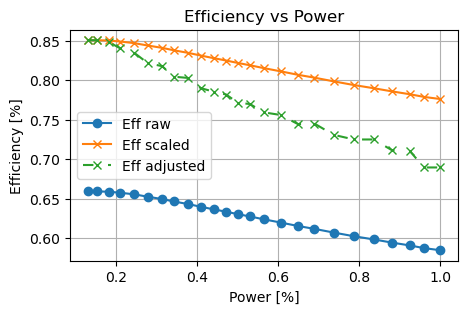

In [30]:
# Plot the data of the original efficiency curve and the adjusted ones
plt.figure(figsize=(5, 3))
plt.plot(df_efficiency_electrolyzer_adj['Power [%]'], df_efficiency_electrolyzer_adj['Efficiency [%]'], label='Eff raw', marker='o')
plt.plot(df_efficiency_electrolyzer_adj['Power [%]'], df_efficiency_electrolyzer_adj['Efficiency_scaled [%]'], label='Eff scaled', marker='x')
plt.plot(df_efficiency_adj['Power [%]'], df_efficiency_adj['eff_adjusted_electrolyzer'], label='Eff adjusted', marker='x', 
         linestyle='dashed', dashes=(5, 7))

plt.xlabel('Power [%]')
plt.ylabel('Efficiency [%]')
plt.title('Efficiency vs Power')
plt.legend()
plt.grid(True)
plt.show()

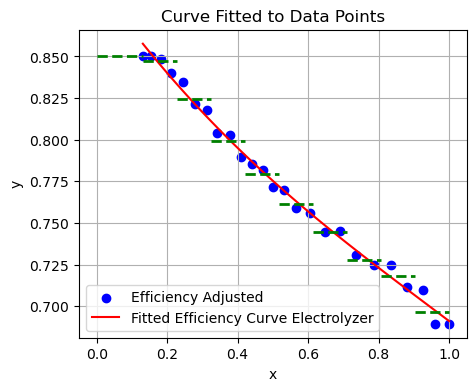

In [31]:
# Plotting the data points and the curve
plt.figure(figsize=(5, 4))
plt.scatter(df_efficiency_electrolyzer_adj['Power [%]'], df_efficiency_electrolyzer_adj['eff_adjusted_electrolyzer'], color='blue', label='Efficiency Adjusted')
plt.plot(x_values_electrolyzer, y_values_electrolyzer, color='red', label='Fitted Efficiency Curve Electrolyzer')

# Plotting segment averages
for i, (x_start, x_end) in enumerate(segment_x_values_electrolyzer):
    plt.plot([x_start, x_end], [segment_averages_electrolyzer[i], segment_averages_electrolyzer[i]], color='green', linestyle='--', linewidth=2)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Curve Fitted to Data Points')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
###Summarize all variable efficiencies
#Collect all data frames that start with variable_efficiency
dfs = [value for key, value in globals().items() if key.startswith('variable_efficiency') and isinstance(value, pd.DataFrame)]

#Choose the first column with the most segments
longest_df = max(dfs, key=lambda df: df.shape[0])
first_column = longest_df.iloc[:, 0]

#Concatenate the remaining columns from all DataFrames, ensuring no duplicate "first column"
remaining_columns = [df.iloc[:, 1:] for df in dfs]

#Concatenate the remaining columns to the longest first column
df_variable_efficiency = pd.concat([first_column] + remaining_columns, axis=1)
df_variable_efficiency

,relationship_class_name:,unit__from_node__user_constraint,unit__to_node__user_constraint
0,User_constraint_name,EffCurve_Electrolyzer,EffCurve_Electrolyzer
1,Object_name,Electrolyzer,Electrolyzer
2,Node_name,Power_Kasso,Hydrogen_Kasso
3,Parameter,unit_flow_coefficient,unit_flow_coefficient
4,0,0.850408,-1.0
5,1,0.847299,NaN
6,2,0.824582,NaN
7,3,0.798963,NaN
8,4,0.779573,NaN
9,5,0.76159,NaN


In [33]:
###Summarize all operating points
#Collect all data frames that start with operating_points
dfs = [value for key, value in globals().items() if key.startswith('operating_points') and isinstance(value, pd.DataFrame)]

#Choose the first column with the most segments
longest_df = max(dfs, key=lambda df: df.shape[0])
first_column = longest_df.iloc[:, 0]

#Concatenate the remaining columns from all DataFrames, ensuring no duplicate "first column"
remaining_columns = [df.iloc[:, 1:] for df in dfs]

#Concatenate the remaining columns to the longest first column
df_operating_points = pd.concat([first_column] + remaining_columns, axis=1)

In [34]:
###Summarize all ordered_unit_flow_op
#Collect all data frames that start with ordered_unit_flow_op
dfs = [value for key, value in globals().items() if key.startswith('ordered_unit_flow_') and isinstance(value, pd.DataFrame)]

#Concatenate the remaining columns to the longest first column
df_boolean_relations = pd.concat(dfs, ignore_index=True)

#### Demand and Renewables Availability:

In [35]:
#create table headers and relations
column_names_1 = {'DateTime '+area: [None, None],
                'Hydrogen_Kasso': ['node','demand'], 
                'E-Methanol_Kasso': ['node','demand'], 
                'Solar_Plant_Kasso': ['unit','unit_availability_factor']}
df_blank_table_1 = pd.DataFrame(column_names_1, index=None)
#add values
df_temp_1 = pd.DataFrame(columns=['DateTime ' + area, 'Hydrogen_Kasso', 'E-Methanol_Kasso', 'Solar_Plant_Kasso'])

df_temp_1['DateTime '+area] = df_time
df_temp_1['Hydrogen_Kasso'] = 0
df_temp_1['E-Methanol_Kasso'] = 25
df_temp_1['Solar_Plant_Kasso'] = df_PV_availabilityfactors_values['unit_availability_factor']

df_table_1 = pd.concat([df_blank_table_1, df_temp_1])
#show table head for control
df_table_1.head()

,DateTime DK1,Hydrogen_Kasso,E-Methanol_Kasso,Solar_Plant_Kasso
0,None,node,node,unit
1,None,demand,demand,unit_availability_factor
0,2019-01-01T00:00:00,0,25,0.0
1,2019-01-01T01:00:00,0,25,0.0
2,2019-01-01T02:00:00,0,25,0.0


#### Energy prices:

In [36]:
column_names_2 = {'DateTime ' + area: ['relationship class','connection','node','parameter name'],
                'Power_Wholesale_In': ['connection__from_node','power_line_Wholesale_Kasso','Power_Wholesale','connection_flow_cost'], 
                'Power_Wholesale_Out': ['connection__to_node','power_line_Wholesale_Kasso','Power_Wholesale','connection_flow_cost'], 
                'District_Heating': ['connection__to_node','pipeline_District_Heating','District_Heating','connection_flow_cost']}
df_blank_table_2 = pd.DataFrame(column_names_2, index=None)
df_temp_2 = pd.DataFrame(columns=['DateTime ' + area, 'Power_Wholesale_In', 'Power_Wholesale_Out', 'District_Heating'])

df_temp_2['DateTime ' + area] = df_time
df_temp_2['Power_Wholesale_In'] = df_powerprices_values['SpotPriceEUR']
df_temp_2['Power_Wholesale_Out'] = -1 * df_powerprices_values['SpotPriceEUR']
df_temp_2['District_Heating'] = -1 * df_district_heating_price[str(year)].loc[2] * share_of_dh_price_cap

df_table_2 = pd.concat([df_blank_table_2, df_temp_2], ignore_index=True)
#show table head for control
df_table_2.head()

,DateTime DK1,Power_Wholesale_In,Power_Wholesale_Out,District_Heating
0,relationship class,connection__from_node,connection__to_node,connection__to_node
1,connection,power_line_Wholesale_Kasso,power_line_Wholesale_Kasso,pipeline_District_Heating
2,node,Power_Wholesale,Power_Wholesale,District_Heating
3,parameter name,connection_flow_cost,connection_flow_cost,connection_flow_cost
4,2019-01-01T00:00:00,28.32,-28.32,-18.579088


#### Time Series Storage:

In [37]:
#date index
before = start_date-timedelta(hours=1)
date_index_beginning = pd.date_range(start=before, end=start_date, freq='H')
formatted_beginning = date_index_beginning.strftime('%Y-%m-%dT%H:%M:%S')
df_formatted_beginning = pd.DataFrame(formatted_beginning, columns=['DateTime'])
df_time_beginning = pd.DataFrame(df_formatted_beginning)
#add one blank row
new_row = pd.Series([])
df_time_beginning = pd.concat([pd.DataFrame([new_row]), df_time_beginning]).reset_index(drop=True)

#concat raw data with time index
storage_values = df_model_storages.iloc[:,[0, 1, 2, 6]]
storage_values = storage_values.iloc[:, [0, 3, 1, 2]]
storage_values_transposed = storage_values.T
storage_values_transposed.columns = storage_values_transposed.iloc[0]
storage_values_transposed = storage_values_transposed[1:]
storage_values_transposed.reset_index(drop=True, inplace=True)

df_storage = pd.concat([df_time_beginning, storage_values_transposed], axis=1)
#show table head for control
df_storage.head()

,DateTime,Hydrogen_storage_Kasso,E-Methanol_storage_Kasso
0,NaN,fix_node_state,fix_node_state
1,2018-12-31T23:00:00,0,0
2,2019-01-01T00:00:00,NaN,NaN


#### Model relations:

In [38]:
#Writing definition of model components
column_names_model_components = {'Object_class_name':['model','temporal_block','stochastic_scenario', 'stochastic_structure', 'report'],
                      'Object_name': [model_name, temporal_block, stochastic_scenario, stochastic_structure, report_name]}
df_model_components = pd.DataFrame(column_names_model_components, index=None)
#outputs:
df_outputs = pd.DataFrame({
    'Object_class_name': ['output']*len(reports),
    'Object_name': reports
})
df_model_components = pd.concat([df_model_components, df_outputs], axis=0)
df_model_components = df_model_components.reset_index(drop=True)

In [39]:
#reports
column_names_model_structure = {'Object_class_name':['model','temporal_block','stochastic_scenario', 'stochastic_structure', 'report'],
                      'Object_name': [model_name, temporal_block, stochastic_scenario, stochastic_structure, report_name]}
df_reports = pd.DataFrame({
    'Relationship_class_name': ['report__output']*len(reports),
    'Object_class_name_1': ['report']*len(reports),
    'Object_class_name_2': ['output']*len(reports),
    'Object_name_1': [report_name]*len(reports),
    'Object_name_2': reports
})
#everything else
df_model_struc = pd.DataFrame({
    'Relationship_class_name': ['model__temporal_block','model__default_temporal_block', 
                                'model__stochastic_structure', 'model__default_stochastic_structure',
                                'stochastic_structure__stochastic_scenario', 'model__report'],
    'Object_class_name_1': ['model','model','model','model','stochastic_structure','model'],
    'Object_class_name_2': ['temporal_block', 'temporal_block','stochastic_structure','stochastic_structure', 'stochastic_scenario','report'],
    'Object_name_1': [model_name, model_name,model_name,model_name,stochastic_structure, model_name],
    'Object_name_2': [temporal_block, temporal_block, stochastic_structure, stochastic_structure, stochastic_scenario, report_name]
})
df_model_relations = pd.concat([df_model_struc, df_reports], axis=0)
df_model_relations = df_model_relations.reset_index(drop=True)
#show table head for control
df_model_relations.head()

,Relationship_class_name,Object_class_name_1,Object_class_name_2,Object_name_1,Object_name_2
0,model__temporal_block,model,temporal_block,toy,hourly
1,model__default_temporal_block,model,temporal_block,toy,hourly
2,model__stochastic_structure,model,stochastic_structure,toy,deterministic
3,model__default_stochastic_structure,model,stochastic_structure,toy,deterministic
4,stochastic_structure__stochastic_scenario,stochastic_structure,stochastic_scenario,deterministic,realisation


#### Model:

In [40]:
### take first 3 columns and add another table with "Alternative", "Value"
column_names_model = {'Object_class_name':['model','model','temporal_block'],
                      'Object_name': [model_name, model_name, temporal_block],
                      'Parameter':['model_start','model_end','resolution'],
                      'Alternative': [scenario, scenario, scenario],
                      'Value': ['{"type": "date_time", "data": "'+df_time.iloc[0]['DateTime']+'"}',
                          '{"type": "date_time", "data": "'+df_time.iloc[-1]['DateTime']+'"}', 
                          '{"type":"duration", "data": "'+frequency+'"}']}
df_model = pd.DataFrame(column_names_model, index=None)
#show table head for control
df_model.head()

,Object_class_name,Object_name,Parameter,Alternative,Value
0,model,toy,model_start,Base,"{""type"": ""date_time"", ""data"": ""2019-01-01T00:0..."
1,model,toy,model_end,Base,"{""type"": ""date_time"", ""data"": ""2019-12-31T23:0..."
2,temporal_block,hourly,resolution,Base,"{""type"":""duration"", ""data"": ""1h""}"


In [41]:
# add information in case roll forward is used
if roll_forward_use == True:
    if temporal_block == 'hourly':
        unit = 'h'
    elif temporal_block == 'daily':
        unit = 'D'
    elif temporal_block == 'monthly':
        unit = 'M'
    else:
        unit = ''
        print("\033[91mWARNING:\033[0m Duration not defined!!!")
    #now add the new row to the df
    roll_forward_size_with_unit = str(roll_forward_size) + unit
    roll_forward_row = {'Object_class_name': 'model', 
                        'Object_name': model_name, 
                        'Parameter': 'roll_forward',
                        'Alternative': scenario,
                        'Value': '{"type": "duration", "data": "' + roll_forward_size_with_unit +'"}'
                       }
    # Add new row to df_model DataFrame
    df_model.loc[len(df_model)] = roll_forward_row

### Creating one combined excel and export

In [42]:
#create the prepared input excel for the use in SpineToolbox
with pd.ExcelWriter(output_file_path + output_file_name) as writer:
    df_definition.to_excel(writer, sheet_name='Definition', index=False)
    unit_parameters_rest_df.to_excel(writer, sheet_name='Definition_parameters', index=False)
    unit_parameters_duration_df.to_excel(writer, sheet_name='Definition_parameters_duration', index=False)
    df_nodes.to_excel(writer, sheet_name='Nodes', index=False)
    df_connections.to_excel(writer, sheet_name='Connections', index=False)
    df_object__node_definitions.to_excel(writer, sheet_name='Object__to_from_node_definition', index=False)
    df_object__node_values.to_excel(writer, sheet_name='Object__to_from_node', index=False)
    df_boolean_relations.to_excel(writer, sheet_name='Boolean_relations', index=False)
    df_object_node_node.to_excel(writer, sheet_name='Object__node_node', index=False)
    df_variable_efficiency.to_excel(writer, sheet_name='Variable_Eff', index=False)
    df_operating_points.to_excel(writer, sheet_name='Operating_points', index=False)
    df_storage.to_excel(writer, sheet_name='Time_series_storage', index=False)
    df_table_1.to_excel(writer, sheet_name='Demand', index=False)
    df_table_2.to_excel(writer, sheet_name='Energy_prices', index=False)
    df_model_components.to_excel(writer, sheet_name='Model_components', index=False)
    df_model_relations.to_excel(writer, sheet_name='Model_relations', index=False)
    df_model.to_excel(writer, sheet_name='Model', index=False)

PermissionError: [Errno 13] Permission denied: '../01_input_data/02_input_prepared/methanol_Input_prepared.xlsx'